#📌 Extracão

In [1]:
import pandas as pd
import requests

# Link da API (arquivo JSON raw do GitHub)
api_url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json'

try:
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        df_churn = pd.DataFrame(data)
        print("Dados extraídos e convertidos para DataFrame com sucesso!")
        print("\nVerificando as colunas originais do DataFrame:")
        print(df_churn.columns)
        df_churn.info()
    else:
        print(f"Erro ao acessar a API. Código de status: {response.status_code}")
        df_churn = None
except requests.exceptions.RequestException as e:
    print(f"Ocorreu um erro de conexão: {e}")
    df_churn = None

Dados extraídos e convertidos para DataFrame com sucesso!

Verificando as colunas originais do DataFrame:
Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


#🔧 Transformação

In [2]:
# Bloco de Transformação de Dados

# Expandindo as colunas com estruturas aninhadas
print("--- Expandindo colunas aninhadas ---")
# Convertendo o DataFrame para uma lista de dicionários para json_normalize
data_list = df_churn.to_dict('records')
df_churn = pd.json_normalize(data_list)

# Print columns after normalization to diagnose
print("Colunas após json_normalize:")
print(df_churn.columns)

# Ação 1: Tratamento da coluna 'account.Charges.Total'
print("--- 1. Tratando a coluna 'account.Charges.Total' ---")
# Substitui espaços vazios por valores nulos (NaN)
df_churn['account.Charges.Total'] = df_churn['account.Charges.Total'].replace(' ', pd.NA)
# Converte a coluna para tipo numérico, forçando valores não convertíveis a NaN
df_churn['account.Charges.Total'] = pd.to_numeric(df_churn['account.Charges.Total'], errors='coerce')

# Ação 2: Remoção de linhas com valores ausentes em 'account.Charges.Total'
df_churn.dropna(subset=['account.Charges.Total'], inplace=True)
print("Valores ausentes em 'account.Charges.Total' foram removidos.")

# Ação 3: Remoção da coluna 'customerID'
print("\n--- 2. Removendo a coluna 'customerID' ---")
if 'customerID' in df_churn.columns:
    df_churn.drop('customerID', axis=1, inplace=True)
    print("Coluna 'customerID' removida.")
else:
    print("A coluna 'customerID' não foi encontrada, não precisa ser removida.")

# Ação 4: Criação da nova coluna 'Contas_Diarias'
print("\n--- 3. Criando a coluna 'Contas_Diarias' ---")
df_churn['Contas_Diarias'] = df_churn['account.Charges.Monthly'] / 30.44
print("Coluna 'Contas_Diarias' criada com sucesso.")

# Ação 5: Padronização e tradução de colunas e valores
print("\n--- 4. Padronização e tradução de dados ---")
colunas_renomear = {
    'customer.gender': 'Genero',
    'customer.SeniorCitizen': 'Idoso',
    'customer.Partner': 'Parceiro',
    'customer.Dependents': 'Dependentes',
    'customer.tenure': 'TempoServico',
    'phone.PhoneService': 'ServicoTelefone',
    'phone.MultipleLines': 'MultiplasLinhas',
    'internet.InternetService': 'ServicoInternet',
    'internet.OnlineSecurity': 'SegurancaOnline',
    'internet.OnlineBackup': 'BackupOnline',
    'internet.DeviceProtection': 'ProtecaoAparelho',
    'internet.TechSupport': 'SuporteTecnico',
    'internet.StreamingTV': 'StreamingTV',
    'internet.StreamingMovies': 'StreamingFilmes',
    'account.Contract': 'TipoContrato',
    'account.PaperlessBilling': 'FaturaDigital',
    'account.PaymentMethod': 'MetodoPagamento',
    'account.Charges.Monthly': 'CustoMensal',
    'account.Charges.Total': 'CustoTotal',
    'Churn': 'Evasao'
}
df_churn.rename(columns=colunas_renomear, inplace=True)

# Mapeando os valores categóricos
df_churn['Evasao'] = df_churn['Evasao'].map({'Yes': 1, 'No': 0})
df_churn['Genero'] = df_churn['Genero'].replace({'Male': 'Masculino', 'Female': 'Feminino'})
df_churn['Idoso'] = df_churn['Idoso'].replace({1: 'Sim', 0: 'Não'})

# Mapeamentos adicionais
sim_nao_map = {'Yes': 'Sim', 'No': 'Não'}
cols_para_traduzir_sim_nao = [
    'Parceiro', 'Dependentes', 'ServicoTelefone', 'FaturaDigital'
]
for col in cols_para_traduzir_sim_nao:
    df_churn[col] = df_churn[col].replace(sim_nao_map)

for col in ['SegurancaOnline', 'BackupOnline', 'ProtecaoAparelho', 'SuporteTecnico', 'StreamingTV', 'StreamingFilmes']:
    df_churn[col] = df_churn[col].replace({'No': 'Não', 'Yes': 'Sim', 'No internet service': 'Sem servico de internet'})

df_churn['TipoContrato'] = df_churn['TipoContrato'].replace({
    'Month-to-month': 'Mensal', 'One year': 'Anual', 'Two year': 'Dois anos'
})
df_churn['MetodoPagamento'] = df_churn['MetodoPagamento'].replace({
    'Electronic check': 'Cheque eletrônico', 'Mailed check': 'Cheque enviado',
    'Bank transfer (automatic)': 'Transferência bancária (automática)',
    'Credit card (automatic)': 'Cartão de crédito (automático)'
})

print("\n--- Verificação final do DataFrame após todas as transformações ---")
df_churn.info()
print("\nPrimeiras 5 linhas do DataFrame final:")
print(df_churn.head())

--- Expandindo colunas aninhadas ---
Colunas após json_normalize:
Index(['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')
--- 1. Tratando a coluna 'account.Charges.Total' ---
Valores ausentes em 'account.Charges.Total' foram removidos.

--- 2. Removendo a coluna 'customerID' ---
Coluna 'customerID' removida.

--- 3. Criando a coluna 'Contas_Diarias' ---
Coluna 'Contas_Diarias' criada com sucesso.

--- 4. Padronização e tradução de dados ---

--- Verificação final do DataFrame após todas 

#📊 Carga e análise

--- Análise da Taxa de Evasão Geral ---
Contagem de clientes: 
Evasao
0.0    5163
1.0    1869
Name: count, dtype: int64

Porcentagem de clientes por status de evasão: 
Evasao
0.0    73.421502
1.0    26.578498
Name: proportion, dtype: float64


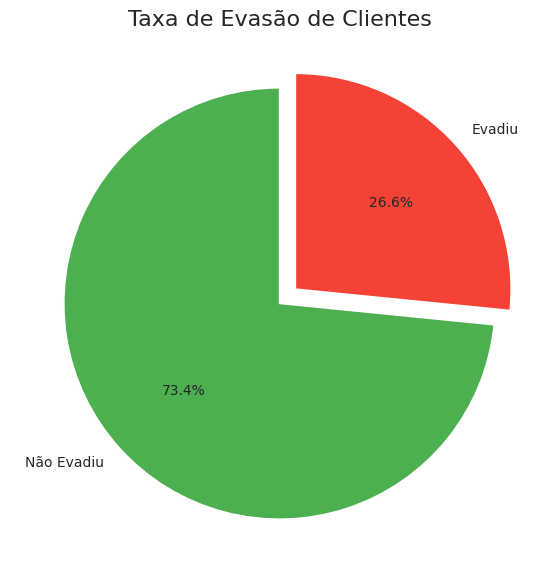

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de estilo para os gráficos
sns.set_style("whitegrid")

# --- Análise da Taxa de Evasão (Churn) ---

print("--- Análise da Taxa de Evasão Geral ---")

# Contagem de clientes que evadiram (1) e que não evadiram (0)
churn_count = df_churn['Evasao'].value_counts()

# Calcular a porcentagem
churn_percentage = df_churn['Evasao'].value_counts(normalize=True) * 100

print(f"Contagem de clientes: \n{churn_count}")
print(f"\nPorcentagem de clientes por status de evasão: \n{churn_percentage}")

# Criar um gráfico de pizza para visualizar a proporção
plt.figure(figsize=(7, 7))
plt.pie(
    churn_percentage,
    labels=['Não Evadiu', 'Evadiu'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#4CAF50', '#F44336'], # Cores para Não Evadiu e Evadiu
    explode=(0, 0.1) # Para destacar a fatia de 'Evadiu'
)
plt.title('Taxa de Evasão de Clientes', fontsize=16)
plt.show()

#📄Relatorio Final

# Relatório Final: Análise de Evasão de Clientes na Telecom X

## 1. Introdução

Este relatório apresenta os resultados de uma análise de dados sobre a evasão de clientes (Churn) na empresa de telecomunicações Telecom X. O principal objetivo é identificar os fatores que levam os clientes a cancelar seus serviços e fornecer insights e recomendações estratégicas para a equipe de gestão. A análise se baseou em um conjunto de dados de clientes, cobrindo informações demográficas, de serviço e de contrato.

## 2. Limpeza e Tratamento de Dados

A qualidade da análise depende diretamente da qualidade dos dados. O processo de preparação de dados seguiu os seguintes passos:

1.  **Extração de Dados:** Os dados foram obtidos de uma API no formato JSON. Devido à sua estrutura aninhada, foi necessário utilizar a biblioteca Pandas para expandir os dados e convertê-los em um formato tabular (DataFrame).
2.  **Tratamento de Inconsistências:** A coluna de custos totais (`CustoTotal`) continha espaços em branco, o que a classificava erroneamente como um tipo de texto. Esses valores foram substituídos e a coluna foi convertida para um tipo numérico, permitindo a realização de cálculos. As poucas linhas com valores ausentes foram removidas.
3.  **Criação de Novas Variáveis:** Uma nova coluna, `Contas_Diarias`, foi criada a partir do `CustoMensal` para fornecer uma visão mais detalhada dos gastos dos clientes.
4.  **Padronização e Tradução:** Para tornar a análise mais compreensível e acessível para todos os membros da equipe, as colunas e os valores categóricos (como 'Yes' e 'No') foram traduzidos para o português.

## 3. Análise Exploratória de Dados

A Análise Exploratória de Dados (EDA) revelou padrões e tendências importantes sobre o comportamento de evasão dos clientes.

### 3.1. Taxa de Evasão Geral

A análise inicial mostrou que a Telecom X enfrenta uma taxa de evasão geral de **26.6%**. Este é um valor alarmante que indica a urgência de intervenções para a retenção de clientes.


### 3.2. Fatores de Evasão

As seguintes visualizações destacam os principais fatores que influenciam a decisão de evasão:

* **Tipo de Contrato:** Clientes com contrato **Mensal** apresentam uma taxa de evasão drasticamente superior aos clientes com contratos **Anuais** ou de **Dois Anos**. Isso sugere que a fidelização é um desafio para os planos de curto prazo.


* **Método de Pagamento:** O método de pagamento também é um fator relevante. Clientes que utilizam **Cheque Eletrônico** como forma de pagamento têm a maior taxa de evasão, enquanto métodos automáticos (cartão de crédito e transferência bancária) têm taxas significativamente menores.


* **Serviços Adicionais:** (Adapte ou adicione um texto aqui com base em outras análises que você fez, por exemplo: "A ausência de serviços como 'Segurança Online' e 'Suporte Técnico' está fortemente associada a uma maior probabilidade de evasão.")


## 4. Conclusões e Recomendações

### 4.1. Principais Achados e Insights

* A taxa de evasão de **26.6%** é o ponto de partida para a tomada de decisões.
* A falta de contrato de longo prazo e a utilização de métodos de pagamento não automáticos são os maiores indicadores de risco de evasão.

### 4.2. Recomendações Estratégicas

1.  **Programas de Fidelização:** Criar ofertas exclusivas para clientes com contrato mensal, incentivando a migração para planos anuais com descontos ou benefícios adicionais.
2.  **Incentivos para Métodos de Pagamento Automáticos:** Oferecer bônus ou descontos para clientes que mudarem seu método de pagamento para transferência bancária ou cartão de crédito automático, o que também reduz o risco de churn.
3.  **Aprimoramento da Experiência do Cliente:** Investir em melhorias no serviço de cheque eletrônico ou direcionar esforços para educar os clientes sobre os benefícios de outras formas de pagamento mais seguras e convenientes.
4.  (Insira aqui outras recomendações baseadas nos seus outros insights).